In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
import whittaker_smooth as ws
from datetime import date
import pandas as pd
import numpy as np  
import utils

## Parameters

In [5]:
lat=  38.153600901211824
lon= -97.73950118113329
initial_date = date(2019, 4, 1)
location = "Kansas"
year = str(initial_date.year)
BASE_DIR = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data\DataExtraction\DataBase\\'+location)
bands =  ['B4','B3','B2','B8']

## 1. Images extraction

In [6]:
# Dictionaries of the images.
images_kansas19 = utils.load_landsat_image(BASE_DIR + '-2019', bands)
images_kansas20 = utils.load_landsat_image(BASE_DIR + '-2020', bands)
images_kansas21 = utils.load_landsat_image(BASE_DIR + '-2021', bands)
images_kansas22 = utils.load_landsat_image(BASE_DIR + '-2022', bands)

# Get the days after plant and the dates.
days_19, dates_19, hours_19 = utils.images_time_info(images_kansas19.keys(), initial_date = date(2019, 4, 1))
days_20, dates_20, hours_20 = utils.images_time_info(images_kansas20.keys(), initial_date = date(2020, 4, 1))
days_21, dates_21, hours_21 = utils.images_time_info(images_kansas21.keys(), initial_date = date(2021, 4, 1))
days_22, dates_22, hours_23 = utils.images_time_info(images_kansas22.keys(), initial_date = date(2023, 4, 1))


## 2. NDVI preprocessing

In [7]:
def dates_for_temperature_extraction(interpolated_days,initial_date=date(2020,4,1)):
    """Calculates dates for a bigger temperature dataset.\n
        Receives interpolated days and the initial date of that year (default is: 2020,04,01). 
        Returns interpolation length set of dates according to days of year."""
    # Calculate day of year
    days_of_year = [round(day) + initial_date.timetuple().tm_yday -1 for day in interpolated_days]
    # Transform day of year to timestamp 
    new_dates = [pd.Timestamp(day, unit='D').replace(year=initial_date.year) for day in days_of_year]
    return new_dates

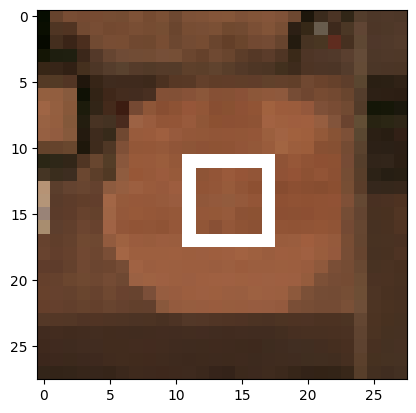

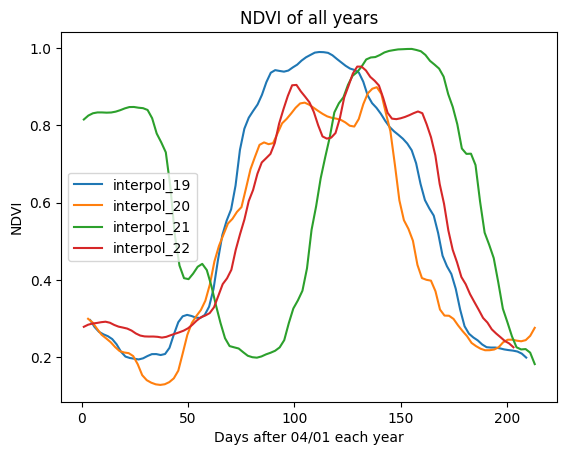

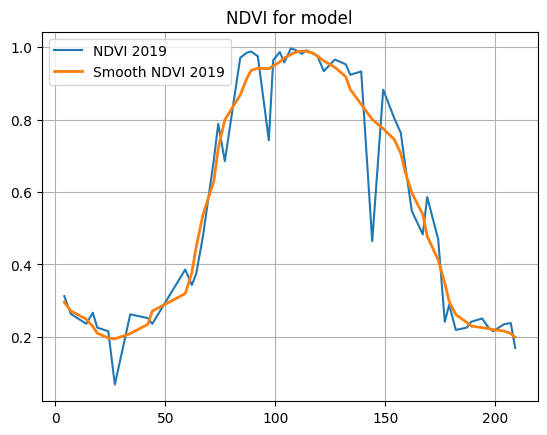

In [8]:
##NDVI
# Calculate the NDVI series over the crops.
ndvi_series_19 = utils.generate_ndvi_time_series(images_kansas19)
ndvi_series_20 = utils.generate_ndvi_time_series(images_kansas20)
ndvi_series_21 = utils.generate_ndvi_time_series(images_kansas21)
ndvi_series_22 = utils.generate_ndvi_time_series(images_kansas22)

# Apply a Whittaker Smooth filter.
ndvi_smooth_19 = ws.whittaker_smooth(np.array(ndvi_series_19), lmbd=10)
ndvi_smooth_20 = ws.whittaker_smooth(np.array(ndvi_series_20), lmbd=10)
ndvi_smooth_21 = ws.whittaker_smooth(np.array(ndvi_series_21), lmbd=10)
ndvi_smooth_22 = ws.whittaker_smooth(np.array(ndvi_series_22), lmbd=10)

# Apply an interpolation by splines.
x_19, y_19 = utils.interpolate_curve(days_19, ndvi_smooth_19)
x_20, y_20 = utils.interpolate_curve(days_20, ndvi_smooth_20)
x_21, y_21 = utils.interpolate_curve(days_21, ndvi_smooth_21)
x_22, y_22 = utils.interpolate_curve(days_22, ndvi_smooth_22)

# Calculate dates for a bigger temperature dataset.
interpol_dates_19 = dates_for_temperature_extraction(x_19,date(2019,4,1))
interpol_dates_20 = dates_for_temperature_extraction(x_20,date(2020,4,1))
interpol_dates_21 = dates_for_temperature_extraction(x_21,date(2021,4,1))
interpol_dates_22 = dates_for_temperature_extraction(x_22,date(2022,4,1))

plt.figure()
plt.plot(x_19, y_19, label='interpol_19')
plt.plot(x_20, y_20, label='interpol_20')
plt.plot(x_21, y_21, label='interpol_21')
plt.plot(x_22, y_22, label='interpol_22')
plt.title('NDVI of all years')
plt.xlabel('Days after 04/01 each year')
plt.ylabel('NDVI')
plt.legend()
plt.show()

##Plotting 
plt.figure()
plt.plot(days_19,ndvi_series_19,label="NDVI 2019") 
plt.plot(days_19,ndvi_smooth_19,linewidth=2,label="Smooth NDVI 2019")
plt.title("NDVI for model")
plt.grid()
plt.legend()



0.09137850635400703
0.011226331353552645


0.1059543833616743

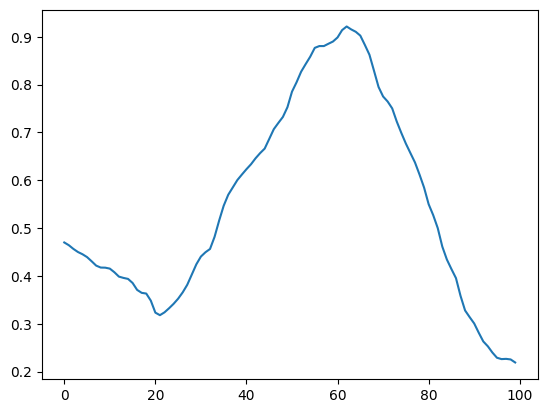

In [9]:
naive=np.mean([y_19,y_20,y_21],axis=0)
plt.plot(naive)
print(mean_absolute_error(y_22,naive))
print(mean_squared_error(y_22,naive))
np.sqrt(mean_squared_error(y_22,naive))

## 3. Historic features extraction

In [10]:
def temperature_extraction(timestamps_list, hours):
    start_dt = date.fromisoformat((min(timestamps_list)).strftime("%Y-%m-%d"))
    end_dt = date.fromisoformat((max(timestamps_list)).strftime("%Y-%m-%d"))

    # Temperature and precipitation database from ERA5 satellite
    features_dict , date_dic = utils.temperature_precipitation_api(date_min=start_dt , date_max=end_dt , hours=hours)

    # Extracted data transformed into a dictionary
    temp_prec_dict = utils.data_extrator_temp(data_tp = features_dict,date_dict_api=date_dic )

    # Get temperature and precipitation from specific dates (according to images dates)
    temp,preci = utils.get_temp_and_preci(temp_prec_dict, timestamps_list)
    return np.array(temp), np.array(preci)

temperature_19, precipitation_19 = temperature_extraction(interpol_dates_19,hours_19)

# Temperature of each year.
temp_19 = temperature_19
temp_20,prec_20 = temperature_extraction(interpol_dates_20,hours_20)
temp_21,prec_21 = temperature_extraction(interpol_dates_21,hours_21)


2022-12-03 22:14:52,080 INFO Welcome to the CDS
2022-12-03 22:14:52,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-12-03 22:14:52,425 INFO Request is completed
2022-12-03 22:14:52,425 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data1/adaptor.mars.internal-1670004105.1907823-29732-11-ca7168bb-caaa-483f-a7f6-a77c9fdba9d2.nc to dataTemperatureCurrent.nc (3K)
2022-12-03 22:14:53,430 INFO Download rate 3K/s
2022-12-03 22:14:54,394 INFO Welcome to the CDS
2022-12-03 22:14:54,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-12-03 22:14:54,816 INFO Request is completed
2022-12-03 22:14:54,818 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data6/adaptor.mars.internal-1670120108.773266-28913-3-b6f68cb6-0bf2-4ace-b308-078adf8b044f.nc to dataTemperatureCurrent.nc (3.2K)
2022-12-03 2

## 4. Features preprocessing

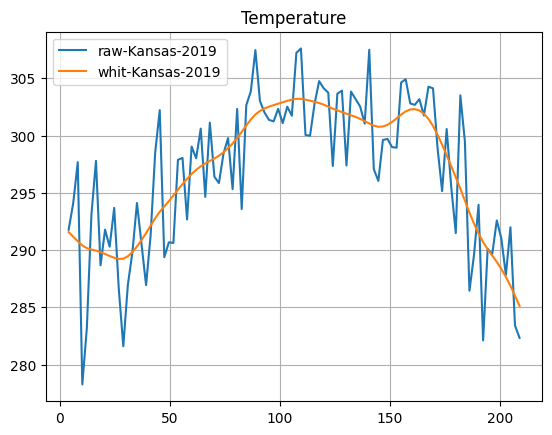

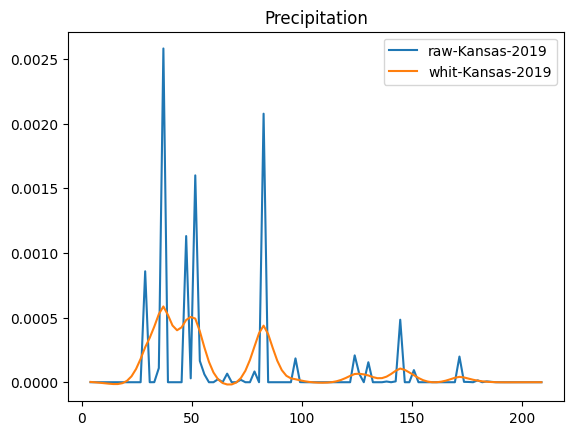

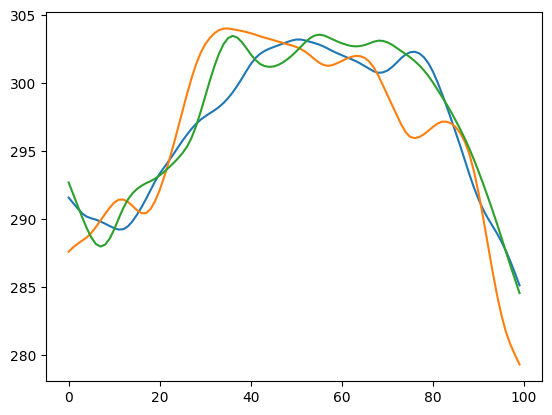

In [11]:
##Features curve smoothing
lmbd = 100

temperature_smooth_19 = ws.whittaker_smooth(temperature_19,lmbd=lmbd,d=2)
precipitation_smooth_19 = ws.whittaker_smooth(precipitation_19,lmbd=10,d=2)

plt.figure(1)
plt.title("Temperature")
plt.plot(x_19,temperature_19,label='raw-'+location+'-'+year)
plt.plot(x_19,temperature_smooth_19,label='whit-'+location+'-'+year)
plt.grid()
plt.legend()

plt.figure(2)
plt.title("Precipitation")
plt.plot(x_19,precipitation_19,label='raw-'+location+'-'+year)
plt.plot(x_19,precipitation_smooth_19,label='whit-'+location+'-'+year)
plt.legend()

#smoothing of all years
temp_smooth_19 = temperature_smooth_19 
temp_smooth_20 = ws.whittaker_smooth(temp_20, lmbd=lmbd)
temp_smooth_21 = ws.whittaker_smooth(temp_21, lmbd=lmbd)
plt.figure()
plt.plot(temp_smooth_19)
plt.plot(temp_smooth_20)
plt.plot(temp_smooth_21)

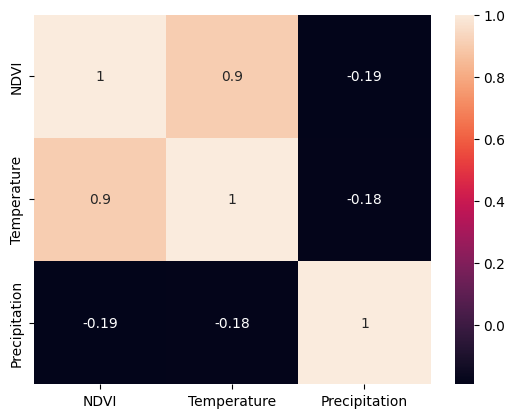

In [12]:
import pandas as pd
import seaborn as sn

data = {'NDVI': y_19,
        'Temperature': temp_smooth_19,
        'Precipitation': precipitation_smooth_19,
        }

df = pd.DataFrame(data)
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

## 5. Model creation
Creation of a model based on 2019 temperature data.

coefficient of determination: 0.8911940195489105


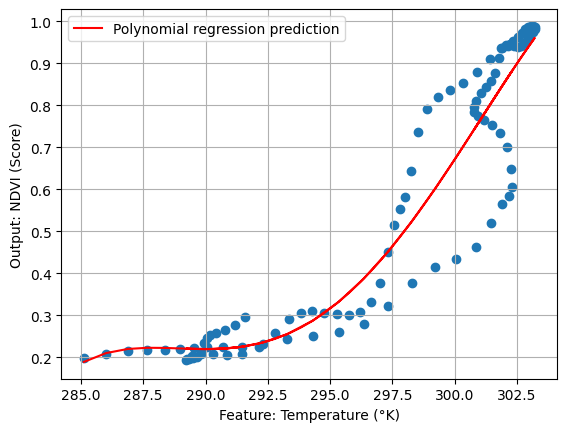

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Reshape to apply function (x must have a column per y value)
x = temp_smooth_19.reshape((-1,1))
y = y_19
plt.figure()
plt.scatter(x,y)

# Transform to apply LinearRegression function
d = 4
transformer = PolynomialFeatures(degree=d, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)

# Apply the model to our transformed x
model_2019 = LinearRegression().fit(x_, y)
y_predict = model_2019.predict(x_)


# Model score
r_sq = model_2019.score(x_, y)
print(f"coefficient of determination: {r_sq}")


plt.plot(x,y_predict,'r',label="Polynomial regression prediction")
plt.ylabel("Output: NDVI (Score)")
plt.xlabel("Feature: Temperature (°K)")
plt.grid()
plt.legend()

# Future temperature extraction

MAE: 0.12650656057565995
MSE: 0.02976926435643886
Normalized: 
MAE: 0.14386009579731143
MSE: 0.03987165734804236


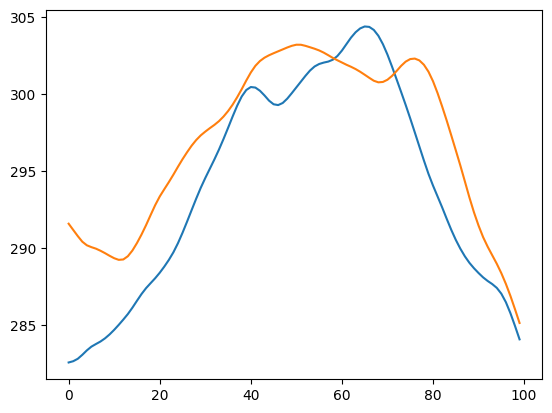

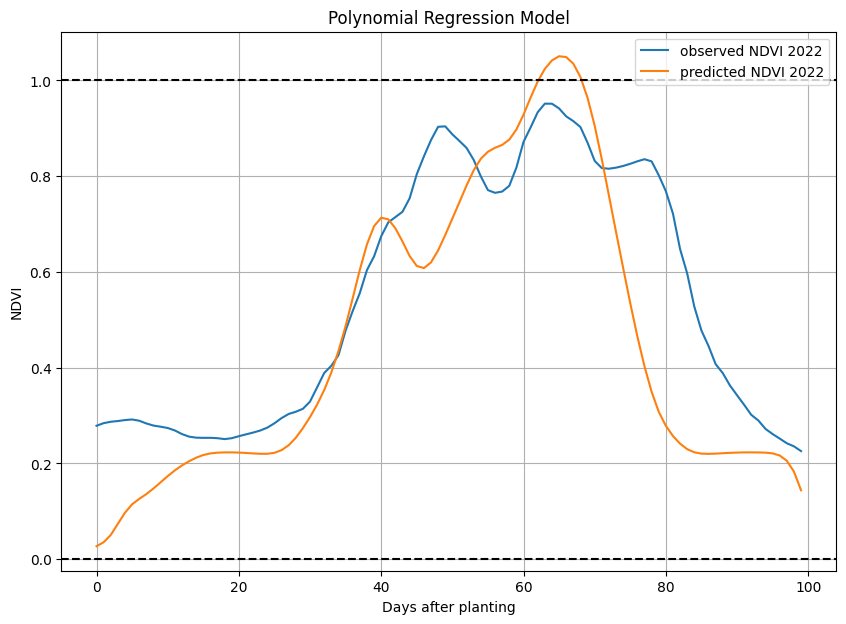

In [14]:
lat = lat
lon = lon

# Temperature prediction from api
temp_prediction_2022, temp_prediction_2023 = utils.future_temperature_values(lat,lon)
initial_date_number = initial_date.timetuple().tm_yday         
days_of_year_22 = [old_date.day_of_year for old_date in interpol_dates_22]     
spec_temp_2022 = [temp_prediction_2022[day] for day in days_of_year_22]    

smooth_temp_22 = ws.whittaker_smooth(np.array(spec_temp_2022),lmbd=100,d=2)

plt.plot(smooth_temp_22)
plt.plot(temp_smooth_19)
x = np.array(smooth_temp_22).reshape((-1,1))
transformer = PolynomialFeatures(degree=d, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)
y_pred_22 = model_2019.predict(x_)

print(f'MAE: {mean_absolute_error(y_22,y_pred_22)}')
print(f'MSE: {mean_squared_error(y_22,y_pred_22)}')

# Normalization
norm_real_22 = [abs(value/max(y_22)) for value in y_22]
norm_pred_22 = [abs(value/max(y_pred_22)) for value in y_pred_22]

print(f'Normalized: \nMAE: {mean_absolute_error(norm_real_22,norm_pred_22)}')
print(f'MSE: {mean_squared_error(norm_real_22,norm_pred_22)}')

# Plot
plt.figure(figsize=(10, 7))
plt.plot(y_22,     label="observed NDVI 2022")
plt.plot(y_pred_22,label="predicted NDVI 2022")
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.title('Polynomial Regression Model')
plt.xlabel('Days after planting')
plt.ylabel('NDVI')
plt.legend(loc='upper right')
plt.grid()
plt.show()



# 2023

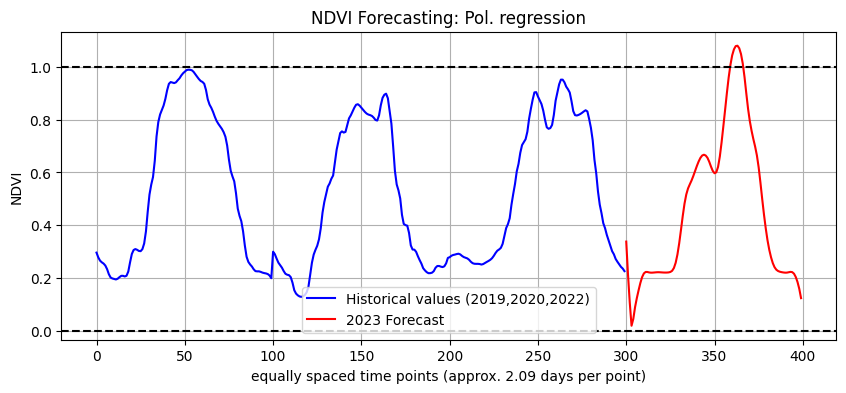

In [15]:
lat = lat
lon = lon

# Temperature prediction from api
temp_prediction_2022, temp_prediction_2023 = utils.future_temperature_values(lat,lon)
initial_date_number = initial_date.timetuple().tm_yday         
days_of_year_23 = [old_date.day_of_year for old_date in interpol_dates_22]     
spec_temp_2023 = [temp_prediction_2023[day] for day in days_of_year_23]    

smooth_temp_23 = ws.whittaker_smooth(np.array(spec_temp_2023),lmbd=100,d=2)


x = np.array(smooth_temp_23).reshape((-1,1))
transformer = PolynomialFeatures(degree=d, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)
y_pred_23 = model_2019.predict(x_)


# Normalization

norm_pred_23 = [abs(value/max(y_pred_23)) for value in y_pred_23]

historic = np.concatenate([y_19,y_20,y_22])
plt.figure(figsize=(10, 4))
plt.plot(historic, color ='blue',label='Historical values (2019,2020,2022)')
plt.plot([i + len(historic) for i in range(len(y_pred_23))], [abs(i) for i in y_pred_23], color= "red",label='2023 Forecast')
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.title('NDVI Forecasting: Pol. regression')
plt.xlabel('equally spaced time points (approx. 2.09 days per point)')
plt.ylabel('NDVI')
plt.grid()
plt.legend(loc='best')
plt.show()

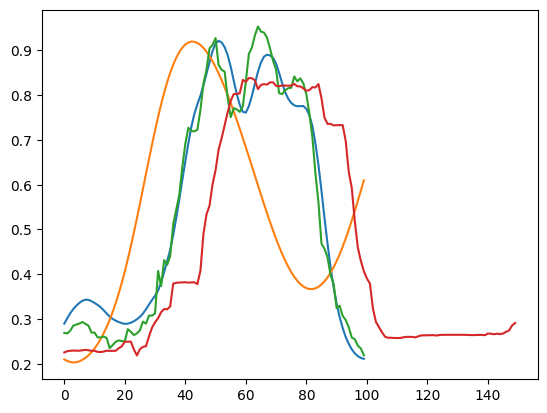

In [16]:

lstm_22 = pd.read_csv('2022-LSTM.csv')
lstm_23 = pd.read_csv('2023-LSTM.csv')
xgb_22 = pd.read_csv('2022-xgboost.csv')
xgb_23 = pd.read_csv('2023-xgboost.csv')
plt.plot(lstm_22)
plt.plot(lstm_23)
plt.plot(xgb_22)
plt.plot(xgb_23)